In [24]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import datetime
from skimage.io import imread
from skimage.transform import resize
from tensorflow.python.framework.ops import reset_default_graph
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
import os
import subprocess
import itertools
import data_utils

import os
import sys
sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
                                         # libraries, like utils.py
import utils # contain various helper funcitons that aren't 
             # important to understand

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[int(row), int(col)] = 1
    return out

# Tying everything together

Now that you have learned about the three most used network architectures: FNNs, CNNs and RNNs. It is time to combine these network types into a more advanced model. 

It often happens that you have a combination of data that cannot fully be modeled by one of these three types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

## Kaggle challenge

In this lab we will work on a data science challenge from [`kaggle.com`](kaggle.com).
Kaggle is a website to participate in real life challenges. Early 2017 it was bought by Google, who wanted access to the global community of data scientists it has created over the last 7 years. Since then Google have sponsored its expansion and now the prizes of the competitions and the amount of public datasets are bigger than ever. Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle [here](https://www.kaggle.com/about) and access a great amount of public datasets [here](https://www.kaggle.com/datasets).

**NB**: You will need a Kaggle account for this exercise!

The challenge we will pursue is the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge.
The dataset consists approximately 1,584 images of leaf specimens (16 samples each of 99 species) which have been converted to binary black leaves against white backgrounds. Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.

We will primarily look into the type of neural network best suited for handling this type of data. 
 * For images, usually the convolutional neural network does a pretty good job, 
 * For timeseries (like the shape) usually the RNN is the network of choice
 * For the describing features a FFN is often a great option

Lastly, we will train the model and put the outputs in a submission file that we can submit to kaggle.

## Visualizing the data

First we start out by looking at the images. We have already downloaded them for you, so all you have to do is to load the files into memory. For this, `glob` is a fantastic tool!

In [25]:
image_paths = glob.glob("images/*.jpg")
print("Amount of images =", len(image_paths))

Amount of images = 1584


Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/). Pandas is probably the most commonly used python library for Data Analysis, so if you have not worked with it before, you should probably check it out. 

In [26]:
# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]
# notice how we "only" have 990 (989+0 elem) images for training, the rest is for testing
train.tail()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
985,1575,Magnolia_Salicifolia,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
986,1578,Acer_Pictum,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
987,1581,Alnus_Maximowiczii,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
988,1582,Quercus_Rubra,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930
989,1584,Quercus_Afares,0.023438,0.019531,0.031250,0.015625,0.005859,0.019531,0.035156,0.0,...,0.000000,0.000000,0.002930,0.000000,0.012695,0.000000,0.000000,0.023438,0.025391,0.022461


With our training data and images loaded into memory. It is time to take a look at the data. Trying to classify leaves does not sound like a particularly difficult or interesting problem. We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at the 99 different categories and come up with a system that discern all 99 types of leaves from each other. 

In [160]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its' index in our list of images in order to find the correct image
indexes = [image_paths.index('images/{}.jpg'.format(i)) for i in species_examples]

# now plot 1 image from each category
fig = plt.figure(figsize=(50, 50))
for i, idx in enumerate(indexes):
    plt.subplot(10, 10, i + 1)
    image = imread(image_paths[idx], as_grey=True)
    plt.imshow(image, cmap='gray')
    plt.title("%s" % (species[i]))
    plt.axis('off')
plt.show()

ValueError: 'images/1525.jpg' is not in list

As you can see, classifying leaves is actually a very tough problem. What makes it even worse, is that we cannot use all the image data we have available. In order to decrease the amount of computations needed, we need to reduce the size of the images as much as possible. On top of that our neural network only accepts fixed size input tensors. This means we will have to resize the images to ensure they all have the same sizes.

This resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner. Describing this leaf without taking its' shape into account seems extremely difficult.

C:\Users\Lucas\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


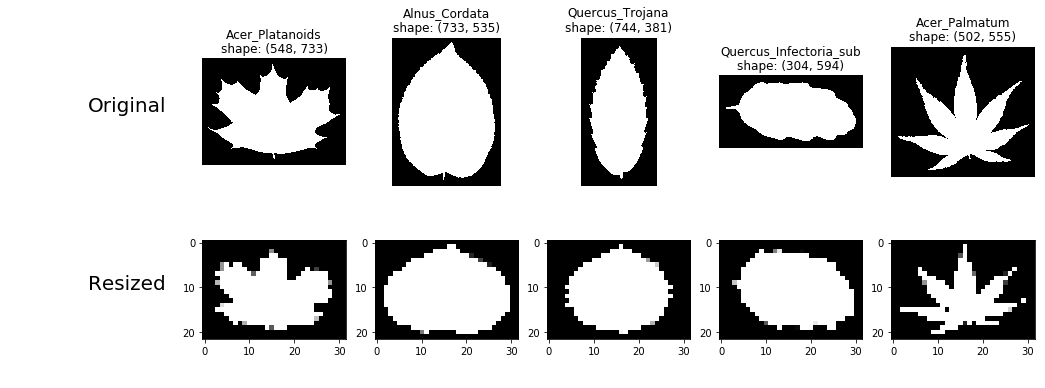

In [161]:
fig = plt.figure(figsize=(18, 6))
amount = 5
image_sample = np.random.choice(train_images, amount)

ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
    
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_grey=True)
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')

ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
    
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_grey=True)
    
    #image = resize(image, output_shape=(300, 300)) # <-- This is the method that resizes the image
    image = resize(image, output_shape=(22, 32)) # <-- This is the method that resizes the image
    
    plt.imshow(image, cmap='gray')
    
plt.show()

In [162]:
# now do similar as in train example above for test.csv
test = pd.read_csv('test.csv')
# notice that we do not have species here, we need to predict that ..!
test.tail()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
589,1576,0.000000,0.000000,0.003906,0.015625,0.041016,0.000000,0.017578,0.000000,0.005859,...,0.098633,0.000000,0.004883,0.000000,0.003906,0.0,0.0,0.018555,0.000000,0.000977
590,1577,0.000000,0.003906,0.003906,0.005859,0.017578,0.000000,0.017578,0.005859,0.000000,...,0.012695,0.004883,0.004883,0.002930,0.009766,0.0,0.0,0.090820,0.000000,0.016602
591,1579,0.017578,0.029297,0.015625,0.013672,0.003906,0.015625,0.025391,0.000000,0.000000,...,0.073242,0.000000,0.028320,0.000000,0.001953,0.0,0.0,0.000000,0.042969,0.006836
592,1580,0.013672,0.009766,0.060547,0.025391,0.035156,0.025391,0.039062,0.000000,0.003906,...,0.003906,0.000000,0.000977,0.000000,0.011719,0.0,0.0,0.000000,0.011719,0.018555
593,1583,0.000000,0.117190,0.000000,0.019531,0.000000,0.136720,0.001953,0.005859,0.000000,...,0.107420,0.012695,0.016602,0.000977,0.004883,0.0,0.0,0.015625,0.000000,0.017578


In [163]:
# and now do similar as in train example above for test.csv
sample_submission = pd.read_csv('sample_submission.csv')
# accordingly to these IDs we need to provide the probability of a given plant being present
sample_submission.tail()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
589,1576,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
590,1577,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
591,1579,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
592,1580,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
593,1583,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101


## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Try to run it a few times to try and get an understanding of how the features differ from species to species.

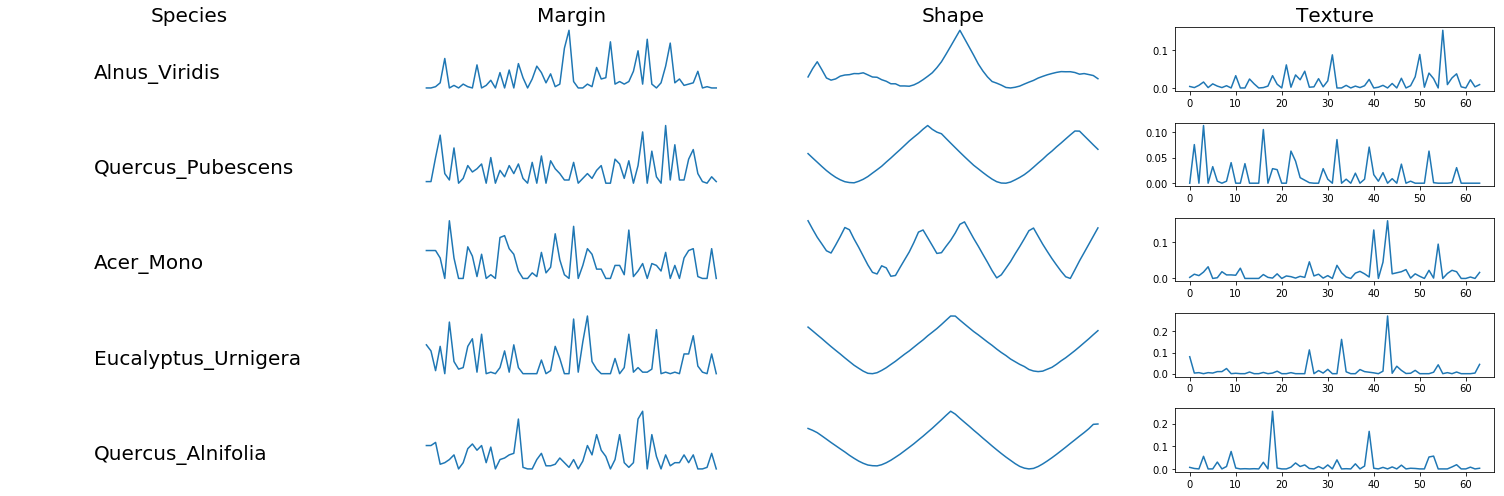

In [164]:
# try and extract and plot columns
X = train.as_matrix()
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5 # Choose the amount of images we want to show at a time
for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)

plt.tight_layout()
plt.show()

# Exercise 1

1. Test various resizings of the image until you have found the smallest resizing of the image where you can still see differentiate between the images. Use IMAGE_SHAPE=(?, ?, 1) to reflect your choices.

So far we have learned about the feed forward neural network, the convolutional neural network and the recurrent neural network.
Given margin and texture are histograms, shape is a contigious value over a "time" dimension 

* (Optional) How could Margin, Shape and Texture be represented for classification?

* (Optional) Describe what network you would build and how you would represent the data points (image, margin, shape and texture).

125,175 seems like a good option. However, it is too slow to train, so I went for 45, 61

# Defining the data loader

In [165]:
print("this is my debugger")


this is my debugger


In [166]:
# loading data and setting up constants
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
IMAGE_PATHS = glob.glob("images/*.jpg")
NUM_CLASSES = 99
IMAGE_SHAPE = (22, 32, 1)
NUM_FEATURES = 64 # for all three features, margin, shape and texture
# train holds both X (input) and t (targeta/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                 test_path=TEST_PATH,
                 image_paths=IMAGE_PATHS,
                 image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
# print
print("@@@Shape checking of data sets@@@")
# print
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
# print()
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

C:\Users\Lucas\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594
@@@Shape checking of data sets@@@
TRAIN
	images	(990, 22, 32, 1)0.462277
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 22, 32, 1)	0.463481
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


# Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

In [167]:
dummy_batch_gen = data_utils.batch_generator(data, batch_size=64, num_classes=99, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))
# notice that mean is very different, which is why we use batch_norm in all input data in model

TRAIN
	images, (64, 22, 32, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

VALID
	images, (64, 22, 32, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

TEST
	images, (64, 22, 32, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ids, 64


# Build the model

### Documentation on contrib layers
Check out the [documentation page](https://www.tensorflow.org/api_docs/python/tf/contrib/layers) for information on contrib layers.

In [243]:
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, batch_norm, max_pool2d, dropout
from tensorflow.python.ops.nn import relu, elu, relu6, sigmoid, tanh, softmax
from tensorflow.python.ops.nn import dynamic_rnn

In [244]:
# wrapping conv with batch_norm
def conv(l_in, num_outputs, kernel_size, scope, stride=1):
    return convolution2d(l_in, num_outputs=num_outputs, kernel_size=kernel_size,
                         stride=stride, normalizer_fn=batch_norm, scope=scope)

# pre-activation: http://arxiv.org/abs/1603.05027
# wrapping convolutions and batch_norm
def conv_pre(l_in, num_outputs, kernel_size, scope, stride=1):
    l_norm = batch_norm(l_in)
    l_relu = relu(l_norm)
    return convolution2d(l_relu, num_outputs=num_outputs, kernel_size=kernel_size,
                         stride=stride, activation_fn=None, scope=scope)

# easy to use pool function
def pool(l_in, scope, kernel_size=(3, 3)):
    return max_pool2d(l_in, kernel_size=kernel_size, scope=scope) # (3, 3) has shown to work better than (2, 2)

In [256]:
# hyperameters of the model
height, width, channels = IMAGE_SHAPE
# resetting the graph ...
reset_default_graph()

# Setting up placeholder, this is where your data enters the graph!
x_image_pl = tf.placeholder(tf.float32, [None, height, width, channels], name="x-image_pl")
x_margin_pl = tf.placeholder(tf.float32, [None, NUM_FEATURES], name="x-margin_pl")
x_shape_pl = tf.placeholder(tf.float32, [None, NUM_FEATURES], name="x-shape_pl")
x_texture_pl = tf.placeholder(tf.float32, [None, NUM_FEATURES], name="x-texture_pl")
is_training_pl = tf.placeholder(tf.bool, name="is-training_pl") #lukl: what is this?

# Building the layers of the neural network
# we define the variable scope, so we more easily can recognise our variables later

## IMAGE
#with tf.name_scope('image-features'):
#    l_conv1_a = conv(x_image_pl, 16, (5, 5), scope="l-conv1_a")
#    l_conv1_a = dropout(l_conv1_a, is_training=is_training_pl, scope="l-conv1_a")
#    l_pool1 = pool(l_conv1_a, scope="l-pool1")
#    l_conv2_a = conv(l_pool1, 16, (5, 5), scope="l-conv2_a")
#    l_pool2 = pool(l_conv2_a, scope="l-pool2")
#    l_conv3_a = conv(l_pool2, 16, (5, 5), scope="l-conv3_a")
#    l_pool3 = pool(l_conv3_a, scope="l-pool3")
#    l_conv4_a = conv(l_pool3, 16, (5, 5), scope="l-conv4_a")
#    l_pool4 = pool(l_conv3_a, scope="l-pool4")
#    l_flatten = flatten(l_pool4, scope="flatten")

## RNN #lukl : ask for explanation here
# define the cell of your RNN
shape_cell = tf.nn.rnn_cell.GRUCell(100)
# run the RNN as outputs, state = tf.nn.dynamic_rnn(cell, ...)
# given we run many-to-one we only care about the last state, so only
# shape_state is defined
_, shape_state = tf.nn.dynamic_rnn(cell=shape_cell,
    inputs=tf.expand_dims(batch_norm(x_shape_pl), 2), dtype=tf.float32, scope="shape_rnn")

## COMBINE
# use margin, shape and texture only
features = tf.concat(values=[x_margin_pl, x_shape_pl, x_texture_pl], axis=1, name="features")
# uncomment to use image only
#features = l_flatten
# uncomment to use margin, rnn_state on shape and texture only
features = tf.concat(axis=1, values=[x_margin_pl, shape_state, x_texture_pl], name="features")
features = batch_norm(features, scope='features_bn')
#l2 = fully_connected(features, num_outputs=256, activation_fn=relu,
#                     normalizer_fn=batch_norm, scope="l2")
#l2 = dropout(l2, is_training=is_training_pl, scope="l2_dropout")
y = fully_connected(features, NUM_CLASSES, activation_fn=softmax, scope="y")
#y = fully_connected(l2, NUM_CLASSES, activation_fn=softmax, scope="y")

# add TensorBoard summaries for all variables
tf.summary.merge_all()

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Model consits of  53563 trainable parameters.


In [257]:
## Launch TensorBoard, and visualize the TF graph
tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
utils.show_graph(tmp_def)

In [258]:
# PRINT NETWORK (good practice to also include outcommented code when using it)

print("x_image_pl,", x_image_pl.get_shape())
print("x_margin_pl,", x_margin_pl.get_shape())
print("x_shape_pl,", x_shape_pl.get_shape())
print("x_texture_pl,", x_texture_pl.get_shape())
print("features,", features.get_shape())
print("y,", y.get_shape())

# for the MLP
#print("l2,", l2.get_shape())
# for the RNN
#print("shape_state,", shape_state.get_shape())
# for the CNN
#print("l_conv1_a,", l_conv1_a.get_shape())
#...
#print("l_pool4,", l_pool4.get_shape())
#print("l_flatten,", l_flatten.get_shape())

x_image_pl, (?, 22, 32, 1)
x_margin_pl, (?, 64)
x_shape_pl, (?, 64)
x_texture_pl, (?, 64)
features, (?, 228)
y, (?, 99)


# Build the cost function

In [259]:
clip_norm = 1
# y_ is a placeholder variable taking on the value of the target batch.
ts_pl = tf.placeholder(tf.float32, [None, NUM_CLASSES], name="targets_pl")
lr_pl = tf.placeholder(tf.float32, [], name="learning_rate_pl")

def loss_and_acc(preds):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(ts_pl * tf.log(preds+1e-10), reduction_indices=[1]) # explaing the 1e-10
    # averaging over samples
    loss = tf.reduce_mean(cross_entropy)
    # if you want regularization
    reg_scale = 0.0001
    regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    #regularize = tf.contrib.layers.l1_regularizer(reg_scale)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    reg_term = sum([regularize(param) for param in params])
    loss += reg_term
    # calculate accuracy
    argmax_y = tf.to_int32(tf.argmax(preds, axis=1))
    argmax_t = tf.to_int32(tf.argmax(ts_pl, axis=1))
    correct = tf.to_float(tf.equal(argmax_y, argmax_t))
    accuracy = tf.reduce_mean(correct)
    return loss, accuracy, argmax_y

### loss, accuracy and prediction
loss, accuracy, prediction = loss_and_acc(y) 

# defining our optimizer
LEARNING_RATE = 0.0005
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)

# applying the gradients
grads_and_vars = optimizer.compute_gradients(loss)
gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
clipped_gradients, global_norm = (
    tf.clip_by_global_norm(gradients, clip_norm) )
clipped_grads_and_vars = zip(clipped_gradients, variables)

# make training op for applying the gradients
train_op = optimizer.apply_gradients(clipped_grads_and_vars)

# make tensorboard summeries
tf.summary.scalar('global_gradient_norm', global_norm)
tf.summary.scalar('Evaluation/loss', loss)
tf.summary.scalar('Evaluation/accuracy', accuracy)

# initialize the Session again to add the new operations
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
sess.run(tf.global_variables_initializer())

In [260]:
#Test the forward pass
_img_shape = tuple([45]+list(IMAGE_SHAPE))
_feature_shape = (45, NUM_FEATURES)
_x_image = np.random.normal(0, 1, _img_shape).astype('float32') #dummy data
_x_margin = np.random.normal(0, 1, _feature_shape).astype('float32')
_x_shape = np.random.normal(0, 1, _feature_shape).astype('float32')
_x_texture = np.random.normal(0, 1, _feature_shape).astype('float32')

# test the forward pass
sess.run(tf.global_variables_initializer())
feed_dict = {x_image_pl: _x_image,
             x_margin_pl: _x_margin,
             x_shape_pl: _x_shape,
             x_texture_pl: _x_texture,
             is_training_pl: False}
res_forward_pass = sess.run(fetches=[y], feed_dict=feed_dict)
print("y", res_forward_pass[0].shape)

y (45, 99)


# TensorBoard

The code above has TensorBoard tracking histograms of all layers, train gradient norm, accuracy, loss, validation accuracy and loss.

The TensorBoard summaries are written to the tensorboard folder. To start TensorBoard run the following command: 

    tensorboard --logdir=tensorboard

in a shell. For ease of use we have included a cell which launches tensorboard in the background

In [250]:
# This cell runs tensorboard in the background which means it can be watched live while training
# Go to http://your.ip.address:6006 in order to see the tensorboard
import subprocess
subprocess.Popen(["tensorboard","--logdir=tensorboard"])

You can also launc tensorboard manually in Jupyter.

In the Jupyter homescreen (where you choose exercises) in the top right click '`New >> Terminal`'. Then open a browser window and connect to `localhost:6006`, here you should find the TensorBoard of your current run.

**DEBUG**: If TensorBoard is empty it is most likely because you aren't pointing the the correct folder.

You can read more about [Tensorboard here](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/).

In [261]:
#Training Loop
BATCH_SIZE = 64
ITERATIONS = 1e4
LOG_FREQ = 10
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for valition
SEED = 42
DROPOUT = True
VALID_EVERY = 100

batch_gen = data_utils.batch_generator(data, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES,
                            num_iterations=ITERATIONS, seed=SEED, val_size=VALIDATION_SIZE)

# setup and write summaries
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summaries_path = "tensorboard/%s" % (timestamp)
summaries = tf.summary.merge_all()

summarywriter_train = tf.summary.FileWriter(summaries_path + '/train', sess.graph)
summarywriter_valid = tf.summary.FileWriter(summaries_path + '/valid', sess.graph)


train_loss = []
train_acc = []
print("\ttrain_loss \ttrain_acc \tvalid_loss \tvalid_acc")
try:
    for i, batch_train in enumerate(batch_gen.gen_train()):
        if i>=ITERATIONS:
            break
        fetches_train = [train_op, loss, accuracy, summaries]
        feed_dict_train = {
            x_image_pl: batch_train['images'],
            x_margin_pl: batch_train['margins'],
            x_shape_pl: batch_train['shapes'],
            x_texture_pl: batch_train['textures'],
            ts_pl: batch_train['ts'],
            is_training_pl: DROPOUT,
            lr_pl: LEARNING_RATE,

        }
        res_train = sess.run(fetches=fetches_train, feed_dict=feed_dict_train)
        if i % LOG_FREQ == 0:
            summarywriter_train.add_summary(res_train[3], i)
        train_loss.append(res_train[1])
        train_acc.append(res_train[2])

        # validate
        if i % VALID_EVERY == 0:
            cur_acc = 0
            cur_loss = 0
            tot_num = 0
            # batch validation
            for batch_valid, num in batch_gen.gen_valid():
                # fetches and feed_dict for validation
                fetches_valid = [loss, accuracy, summaries]
                feed_dict_valid = {
                    x_image_pl: batch_valid['images'],
                    x_margin_pl: batch_valid['margins'],
                    x_shape_pl: batch_valid['shapes'],
                    x_texture_pl: batch_valid['textures'],
                    ts_pl: batch_valid['ts'],
                    is_training_pl: False,
                }
                # run validation
                res_valid = sess.run(fetches=fetches_valid, feed_dict=feed_dict_valid)
                # tensorboard and costs
                cur_loss += res_valid[0]*num   # Validation loss
                cur_acc  += res_valid[1]*num   # Validation accuracy 
                summarywriter_valid.add_summary(res_valid[2], i) # save the vali summary
                tot_num += num

            valid_loss = cur_loss / float(tot_num)
            valid_acc = (cur_acc / float(tot_num)) * 100
            train_loss = sum(train_loss) / float(len(train_loss))
            train_acc = sum(train_acc) / float(len(train_acc)) * 100
            print("%d:\t  %.2f\t\t  %.1f\t\t  %.2f\t\t  %.1f" % (i, train_loss, train_acc, valid_loss, valid_acc))
            train_loss = []
            train_acc = []
except KeyboardInterrupt:
    pass

	train_loss 	train_acc 	valid_loss 	valid_acc
0:	  4.71		  0.0		  3.92		  3.0
100:	  3.92		  11.8		  3.02		  14.2
200:	  3.30		  24.6		  2.74		  21.0
300:	  3.06		  36.1		  2.74		  23.6
400:	  2.86		  43.9		  2.60		  30.7
500:	  2.68		  51.8		  2.47		  39.4
600:	  2.58		  54.0		  2.30		  48.6
700:	  2.45		  59.6		  2.28		  43.9
800:	  2.26		  65.7		  2.12		  49.6
900:	  2.21		  68.2		  2.73		  30.9
1000:	  2.03		  70.5		  2.35		  36.5
1100:	  1.93		  73.9		  1.89		  54.2
1200:	  1.80		  77.5		  2.17		  36.4
1300:	  1.81		  75.3		  1.93		  47.7
1400:	  1.62		  82.3		  2.19		  36.4
1500:	  1.59		  80.8		  1.72		  57.3
1600:	  1.46		  85.3		  1.61		  59.4
1700:	  1.35		  86.9		  1.53		  61.4
1800:	  1.27		  86.4		  1.62		  58.8
1900:	  1.24		  86.3		  1.24		  71.7
2000:	  1.08		  90.9		  1.66		  51.6
2100:	  0.97		  92.2		  1.50		  56.5
2200:	  0.99		  90.0		  1.02		  73.9
2300:	  0.88		  92.6		  1.64		  50.9
2400:	  0.88		  91.2		  1.03		  71.7
2500:	  0.75		  94.2		  1.19		  70.6
2600:	

# Submission to Kaggle

First we have to make testset predictions, then we have to place it in the submission file and the upload to kaggle for our score! You can upload at max 5 submissions a day.

In [51]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test = []
preds_test = []
# run like with validation
for batch_test, num in batch_gen.gen_test():
    # fetching for test we only need y
    fetches_test = [y]
    # same as validation, but no batch['ts']
    feed_dict_test = {
        x_image_pl: batch_test['images'],
        x_margin_pl: batch_test['margins'],
        x_shape_pl: batch_test['shapes'],
        x_texture_pl: batch_test['textures'],
        is_training_pl: False
    }
    # get the result
    res_test = sess.run(fetches=fetches_test, feed_dict=feed_dict_test)
    y_out = res_test[0]
    ids_test.append(batch_test['ids'])
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
# concatenate it all, to form one list/array
ids_test = list(itertools.chain.from_iterable(ids_test))
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

# Make submission file

In [52]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv('submission_mlp.csv', index=False)
# below prints the submission, can be removed and replaced with code block below
submission.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,1026,5.377190e-10,5.749347e-08,4.641194e-07,6.448033e-08,2.978535e-06,6.888417e-09,1.626257e-07,1.510486e-08,1.016306e-08,...,5.244054e-08,3.944821e-05,2.231925e-07,1.001242e-05,2.673022e-04,6.473172e-08,4.196095e-08,1.100950e-05,7.564906e-07,2.233103e-05
1,4,1.995669e-09,1.453974e-09,9.317239e-11,8.297922e-06,1.899373e-09,1.607088e-11,3.537500e-10,4.049628e-09,4.765141e-10,...,9.378435e-10,8.032714e-07,1.693918e-07,1.350108e-10,1.547872e-08,2.486607e-10,1.648998e-10,5.082623e-11,1.045514e-08,4.522535e-11
2,1029,4.794587e-05,3.955082e-06,6.284897e-06,8.340850e-07,2.092488e-05,4.752442e-05,2.229486e-05,1.107452e-05,2.006046e-04,...,2.960558e-03,2.250817e-05,2.216662e-03,1.898815e-04,6.399489e-05,1.751333e-04,1.346045e-02,1.471496e-04,2.303826e-06,4.889588e-06
3,7,2.335556e-11,5.477507e-11,2.828613e-10,2.853440e-08,1.357222e-10,1.994330e-11,3.355178e-06,1.213784e-09,3.091569e-10,...,3.323564e-10,1.551328e-10,1.149727e-09,2.138046e-11,2.013095e-11,3.948054e-08,1.559844e-09,3.162237e-08,1.600565e-11,4.384114e-08
4,9,2.852879e-07,9.947153e-01,9.834423e-07,8.790703e-07,2.142825e-03,1.649956e-05,1.985364e-08,8.661348e-06,2.073155e-05,...,2.111781e-06,1.592573e-06,1.425049e-07,6.923707e-08,7.732942e-09,3.361288e-07,1.654155e-07,6.532431e-08,4.712795e-08,9.725413e-04


# Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/`](https://www.kaggle.com/c/leaf-classification/)
2. Make a submission
3. Click or drop your submission here (writing a description is good practice)
4. Submit

Success! 

## Exercise 2

1. Try to get the best score on Kaggle for this dataset as you can. (You can upload your solution multiple times as you progress)

A good implementation would get a score around 0.06399, try and see if you can get there, and explain what might have gone wrong if you cant. 

When doing trying to improve the network nothing is sacred, you can change learning rate, try testing various learning rates, batch sizes, validation sizes, etc. And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you of to a good start we have created a list of thing you might want to try:
* Include l2 (fully connected and dropout layer)
* Try with L1 regularization (look at [tensorflow API](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/l1_regularizer) for instructions)
* Include Dropout (Set DROPOUT to TRUE)
* Include L2 regularization
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Use dropout between the convolutional layers
* Include the RNN part
* Increase or decrease the batch size 
* Change the image size to be rectangular, bigger or smaller
* Try to combine the FFN, CNN, RNN parts in various ways

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.

### log of tries

- Only one fully connected layer directly to the outputs: accuracy: 0,84 on the test set
- Including l2: the network converges to 100% accuracy in the training set much faster, however it still does not get more than 84 % accuracy. It overfits then.
- Including the L1 with regularization: did not change anything
- Including dropout: same as above, including dropout did not change the validation accuracy
- Including l2 regularization: did not change anything. Tried with different values
- Tested using only the CNN with a image_shape of 22, 32. It was much slower than the previous ones, the number of parameters of the network was 24563. Even though I got a training accuracy of 100%, the validation one only got to 40%. This probably means that species depends on other information rather than the image itself
- Including dropout to all the CNN layers: The accuracy on the validation set dropped to 50%
- Including dropout to only the first convolutional layer: Increased the training accuracy when compared to the case above, but validation accuracy remained on 50%
- RNN + fully connect layer with margin and texture: got an accuracy of 100% on the training set but 78% on the validation

